# Pulsar classification

In [1]:
import pandas as pd
import numpy as np
import itertools

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

## Some functions

**Printing ratio of TRUE class**

In [4]:
def pulsar_ratio(v_count):
    return(v_count[1]/v_count[0])

**Plotting binary classfication metrics** (Confusion matrice, precision and recall)


In [66]:
def plot_binary_class_metrics(cm, precision_scr, recall_scr, title='Confusion matrix', figsize=(5,5)):

    cmap = plt.get_cmap('RdYlGn')
    fig, ax = plt.subplots(figsize=figsize)    
    
    # We want cell (0,0) and (1,1) in green as True Negatives and True Positives
    # We want cell (0,1) and (1,0) in red as False Positives and  False Negatives
    color_mat = np.array([[1,0], [0,1]])
    plt.imshow(color_mat, interpolation='none', alpha = 0.8,
               vmin = 0, vmax = 1, cmap=cmap)
    
    # Set title
    plt.title(title, fontsize = 14)
    #ax.title.set_position([0.5,1])
    
    
    # Set major ticks and ticks labels
    tick_marks = np.arange(2)
    plt.xticks(np.arange(2), ["NOT Pulsar\n(Predicted)", "Pulsar\n(Predicted)"])
    plt.yticks(np.arange(2), ["NOT Pulsar\n(Observed)", "Pulsar\n(Observed)"])
    
    # Set minor ticks for displaying grid
    ax.set_xticks(np.arange(0.5, 1), minor=True)
    ax.set_yticks(np.arange(0.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

    # Display major xticks on Top and yticks on Left
    plt.tick_params(which='major', bottom=False,
                    top=True, labelbottom=False, labeltop=True) 
    
    cm_labels = np.array(["True Negative\n","False Positive\n",
                        "False Negative\n", "True Positive\n"]).reshape(2,2)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0}{1:,}".format(cm_labels[i,j],cm[i, j]), verticalalignment="center",
                 horizontalalignment="center", color="white", fontsize = 12)

    #plt.tight_layout()
    plt.xlabel('Precision: {0:0.3f}\nRecall:{1:0.3f}'.format(precision_scr,recall_scr), fontsize = 14)
    plt.show()

## Getting the data

The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples.

Each observation is described by 8 continuous variables:
* The first four (continuous) variables are simple statistics obtained from the integrated pulse profile (folded profile). They describe a longitude-resolved version of the signal that has been averaged in both time and frequency.
* The remaining four variables are similarly obtained from the DM-SNR curve.

The complete list of the variables are:
	1. Mean of the integrated profile.
	2. Standard deviation of the integrated profile.
	3. Excess kurtosis of the integrated profile.
	4. Skewness of the integrated profile.
	5. Mean of the DM-SNR curve.
	6. Standard deviation of the DM-SNR curve.
	7. Excess kurtosis of the DM-SNR curve.
	8. Skewness of the DM-SNR curve.

In [5]:
filename = "../data/HTRU_2.csv"

#### Define columns, variables and labels

In [6]:
column_names = ["mean_ip",
               "sd_ip",
               "kurt_ip",
               "skew_ip",
               "mean_dmsnr",
               "sd_dmsnr",
               "kurt_dmsnr",
               "skew_dmsnr",
               "is_pulsar"]

# all variables
variables = column_names[:-1]

# labels (last column)
labels = column_names[-1]

#### Read data from data file

In [7]:
pulsars = pd.read_csv(filename,
                     header = None,
                     names = column_names)

In [8]:
pulsars.head(3)

,mean_ip,sd_ip,kurt_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurt_dmsnr,skew_dmsnr,is_pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0


In [9]:
pulsars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
mean_ip       17898 non-null float64
sd_ip         17898 non-null float64
kurt_ip       17898 non-null float64
skew_ip       17898 non-null float64
mean_dmsnr    17898 non-null float64
sd_dmsnr      17898 non-null float64
kurt_dmsnr    17898 non-null float64
skew_dmsnr    17898 non-null float64
is_pulsar     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


### Correlation of explanatory variables
Let's have a look on how explanatory variables are **correlated**.

In [10]:
corr_matrix = pulsars[variables].corr()
corr_matrix

,mean_ip,sd_ip,kurt_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurt_dmsnr,skew_dmsnr
mean_ip,1.000000,0.547137,-0.873898,-0.738775,-0.298841,-0.307016,0.234331,0.144033
sd_ip,0.547137,1.000000,-0.521435,-0.539793,0.006869,-0.047632,0.029429,0.027691
kurt_ip,-0.873898,-0.521435,1.000000,0.945729,0.414368,0.432880,-0.341209,-0.214491
skew_ip,-0.738775,-0.539793,0.945729,1.000000,0.412056,0.415140,-0.328843,-0.204782
mean_dmsnr,-0.298841,0.006869,0.414368,0.412056,1.000000,0.796555,-0.615971,-0.354269
sd_dmsnr,-0.307016,-0.047632,0.432880,0.415140,0.796555,1.000000,-0.809786,-0.575800
kurt_dmsnr,0.234331,0.029429,-0.341209,-0.328843,-0.615971,-0.809786,1.000000,0.923743
skew_dmsnr,0.144033,0.027691,-0.214491,-0.204782,-0.354269,-0.575800,0.923743,1.000000


#### Let's plot the correlation matrix

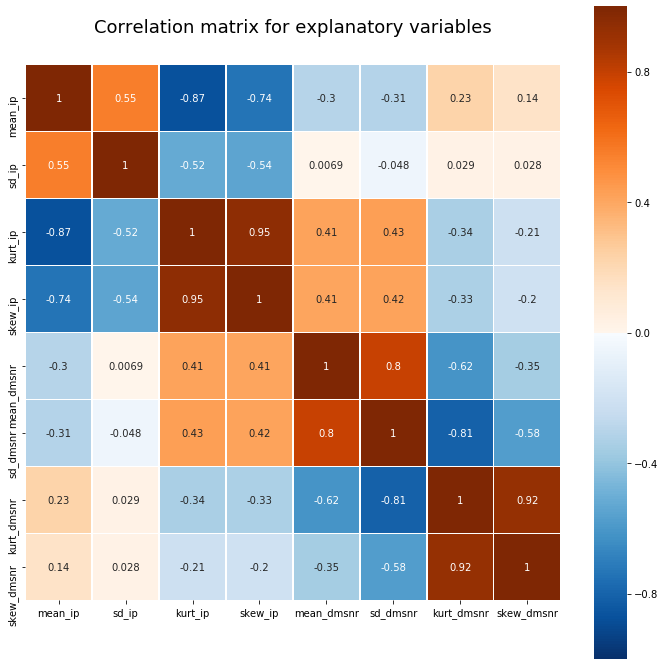

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
plt.title("Correlation matrix for explanatory variables", fontsize = 18)
ax.title.set_position([0.5,1.05])

# Build a custom cmap, positive correlation in orange,
# negative correlation in blue
pos_corr = cm.get_cmap('Oranges_r', 128)
neg_corr = cm.get_cmap('Blues', 128)

custom_colors = np.vstack((neg_corr(np.linspace(1, 0, 128)), pos_corr(np.linspace(1, 0, 128))))
custom_cmp = ListedColormap(custom_colors, name='OrangeBlue')

sns.heatmap(corr_matrix,
            vmin = -1, vmax = 1,
            linewidths = 0.3,
            square = True,
            annot= True,
           cmap = custom_cmp,
           ax = ax)

### Ratio of true pulsars in dataset

In [12]:
print("Ratio of true pulsar in dataset: {0:01.5f}".format(pulsar_ratio(pulsars["is_pulsar"].value_counts())))

Ratio of true pulsar in dataset: 0.10081


So we have **data significantly unbalanced** (i.e. pulsars being only 10% of the dataset). We need to pay attention to keep the same ratio for test and training data.

## Creating training and test dataset

Splitting data into training and test set **at random**.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(pulsars[variables],
                                                   pulsars[labels],
                                                   test_size=0.2, random_state=42)

In [14]:
print("Ratio of true pulsar in train: {0:01.5f}".format(pulsar_ratio(y_train.value_counts())))
print("Ratio of true pulsar in test : {0:01.5f}".format(pulsar_ratio(y_test.value_counts())))

Ratio of true pulsar in train: 0.10138
Ratio of true pulsar in test : 0.09850


The **ratio** is actually not too different than the ratio in the full dataset. Given the numbers of observations, random selection makes a good enough job with regards to the ratio of classes.

---

**Digression:** ```train_test_split``` is actually using ShuffleSplit. I.e. the call to ```train_test_split``` is actually equivallent to:

```python
train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(train_test_splitter.split(pulsars))
X_train = pulsars.iloc[train_idx][variables]
y_train = pulsars.iloc[train_idx][labels]
etc...
```
---

Because ```train_test_split``` is using ```ShuffleSplit```, it does not specifically preserve the ratio of samples for each class.

An alternative would be to use ```StratifiedShuffleSplit```. Out of curiosity, let's see if it makes a significant difference in term of class ratio with the *simple* ```ShuffleSplit```.

In [15]:
ss_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(ss_splitter.split(pulsars[variables], pulsars[labels]))

In [16]:
print("Ratio of true pulsar in train: {0:01.5f}".format(pulsar_ratio(pulsars.iloc[train_idx]["is_pulsar"].value_counts())))
print("Ratio of true pulsar in test : {0:01.5f}".format(pulsar_ratio(pulsars.iloc[test_idx]["is_pulsar"].value_counts())))

Ratio of true pulsar in train: 0.10079
Ratio of true pulsar in test : 0.10086


That's definitively (*marginally!*) better than with ```train_test_split```.

**We are therefore keeping this split for our train and test dataset.**

---

is keptunder the hood, i.e. a splitting by replacement. Shuffling happens before each split, which means that each split **could contain variables already seen previously**.

---

## Classifying using SGD classifier
I.e. a **Stochastic Gradient Descent** classifier

In [17]:
pulsar_clf = SGDClassifier()

### Let's use a simple model at first
with only:
* the mean of the Integrate Profile and,
* the mean of the DM-SNR curve.

In [18]:
model1_feat = ["mean_ip", "mean_dmsnr"]

In [19]:
X_train = pulsars.iloc[train_idx][model1_feat]
y_train = pulsars.iloc[train_idx][labels]

In [20]:
y_predict = cross_val_predict(pulsar_clf, X_train, y_train, cv = 3)

#### Some basic performance indication on this classifier

In [66]:
confusion_mat = confusion_matrix(y_train,y_predict)
precision_scr = precision_score(y_train, y_predict)
recall_scr = recall_score(y_train, y_predict)

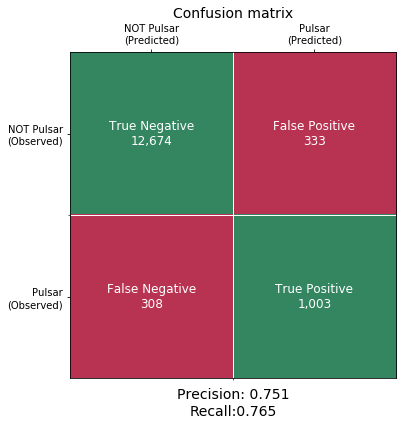

In [76]:
plot_binary_class_metrics(confusion_mat, precision_scr = precision_scr,
                          recall_scr = recall_scr, figsize=(6,6))

### And a more complex model now
with all explanatory variables.

In [103]:
X_train = pulsars.iloc[train_idx][variables]
y_train = pulsars.iloc[train_idx][labels]

In [119]:
y_predict = cross_val_predict(pulsar_clf, X_train, y_train, cv = 3)

#### Some basic performance indication on this classifier

In [120]:
confusion_mat = confusion_matrix(y_train,y_predict)
precision_scr = precision_score(y_train, y_predict)
recall_scr = recall_score(y_train, y_predict)

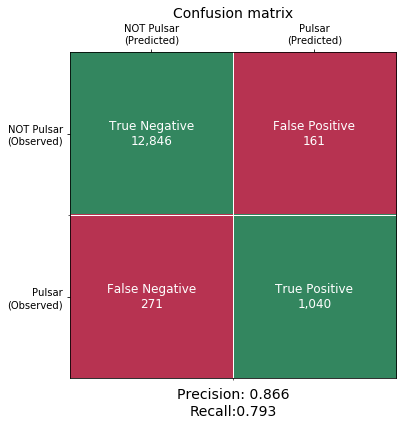

In [121]:
plot_binary_class_metrics(confusion_mat, precision_scr = precision_scr,
                          recall_scr = recall_scr, figsize=(6,6))

#### Let's evaluate Precision vs Recall for this last classifier

In [ ]:
scores = cross_val_predict(pulsar_clf, X_train, y_train, cv = 3, method="decision_function")

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, scores)

In [ ]:
plt.plot(thresholds, precisions[:-1], "b--", label="precision")
plt.plot(thresholds, recalls[:-1], "g-", label="recall")
plt.show()

In [ ]:
thresholds.shape

In [ ]:
precisions.shape

In [ ]:
precisions[:10]

In [ ]:
recalls[:10]

In [ ]:
disp = plot_confusion_matrix(pulsar_clf, X_train, y_train,
                                 display_labels=["0", "1"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("title")


plt.show()

In [ ]:
confusion_matrix(y_test,y_predict)

In [ ]:
y_test.shape

In [ ]:
3250 + 9 + 85 + 236